                    Feature  Importance
0               radius_mean    0.253510
4            concavity_mean    0.221573
10          concavity_worst    0.134033
6                 radius_se    0.086744
9         compactness_worst    0.060536
3          compactness_mean    0.054037
1              texture_mean    0.052421
8          smoothness_worst    0.044140
11           symmetry_worst    0.027406
2           smoothness_mean    0.024723
5             symmetry_mean    0.014992
7         concave points_se    0.014442
12  fractal_dimension_worst    0.011444
FNR: 0.00
FNR: 0.03
ACCURACY SCORE: 0.8859649122807017

Classification Report For Random Forest:
              precision    recall  f1-score   support

      Benign       1.00      0.83      0.91        75
   Malignant       0.75      1.00      0.86        39

    accuracy                           0.89       114
   macro avg       0.88      0.91      0.88       114
weighted avg       0.91      0.89      0.89       114

              pr

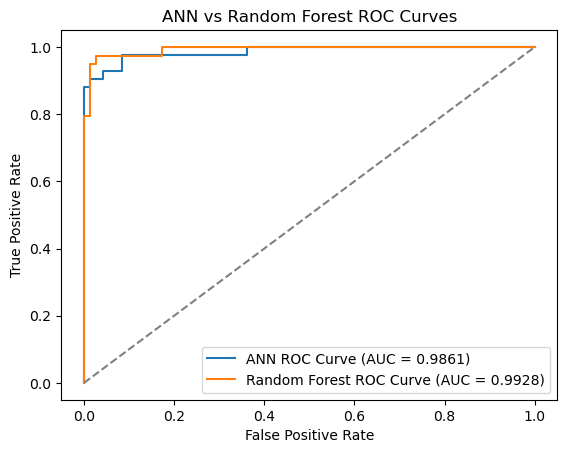

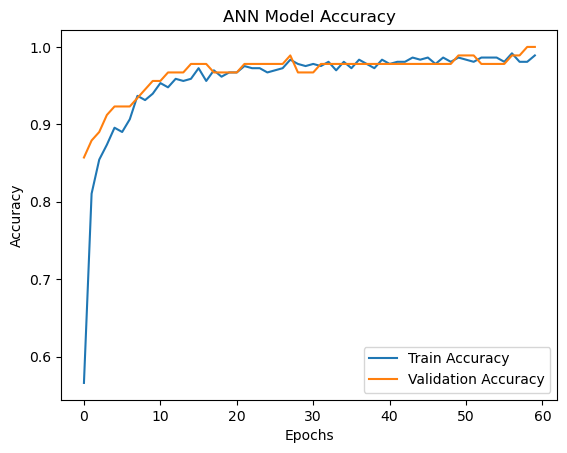

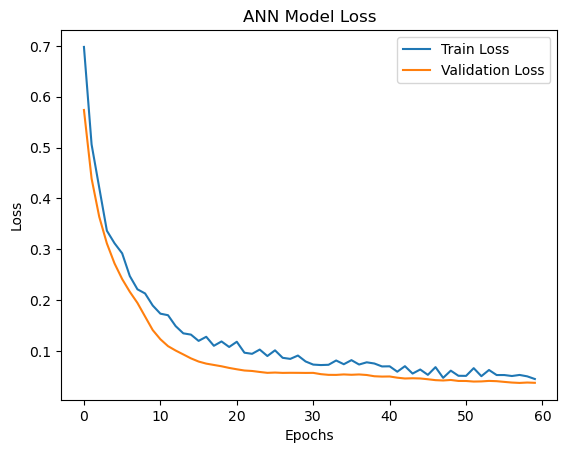

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import math
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import random
import tensorflow as tf


# Set random seeds
random.seed(23)
np.random.seed(23)
tf.random.set_seed(23)

data = pd.read_csv('breastcancer.csv') 
features_selected = ['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 
                     'concavity_mean', 'symmetry_mean', 'radius_se', 'concave points_se', 
                     'smoothness_worst', 'compactness_worst', 'concavity_worst', 
                     'symmetry_worst', 'fractal_dimension_worst'] # Features that were highly correlated when feature selection was done


X1 = data[features_selected]
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})  # Convert labels to binary
y1 = data['diagnosis']


X1 = X1.dropna()
y1 = y1.dropna()

X1 = X1.loc[y1.index] # make sure X & y line up together

#train test
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=23)

#define classifier with best parameters
rf = RandomForestClassifier(
    bootstrap=False,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=100,
    random_state=23
)

# Fit the model
rf.fit(X_train1, y_train1)

#Feature importance
importance = rf.feature_importances_

# Combine with feature names
feature_importance_df = pd.DataFrame({
    'Feature': X1.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

#metrics for Random Forest
y_pred_probs_rf = rf.predict_proba(X_test1)[:,1] 
roc_auc_rf = roc_auc_score(y_test1, y_pred_probs_rf)

#roc and auc
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test1, y_pred_probs_rf)
'''
y_pred_rf = rf.predict(X_test1)
'''
tpr_max_rf=tpr_rf.argmax()
best_thresh_rf=thresholds_rf[tpr_max_rf]

#apply threshold to probabilities
y_pred_rf = (y_pred_probs_rf >= best_thresh_rf).astype(int) 

cm = confusion_matrix(y_test1, y_pred_rf)
cm3 = confusion_matrix(y_test1, rf.predict(X_test1))
TN,FP,FN,TP = cm.ravel()
FNR = FN/(TP+FN)
TN3,FP3,FN3,TP3 = cm3.ravel()
FNR3 = FN3/(TP3+FN3)
print(f'FNR: {FNR:.2f}')
print(f'FNR: {FNR3:.2f}')
#gives accuracy precision F1 of pred vs test
print(f'ACCURACY SCORE: {accuracy_score(y_test1, y_pred_rf)}')
print("\nClassification Report For Random Forest:")
print(classification_report(y_test1, y_pred_rf, target_names=["Benign", "Malignant"]))
print(classification_report(y_test1, rf.predict(X_test1), target_names=["Benign", "Malignant"]))
######################################################-ANN-############################################################
X2 = data[features_selected]
y2 = data['diagnosis']

# training and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=23, stratify=y2)

# scaler
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

# ANN architechture
def create_model(learning_rate=0.001, dropout_rate=0.3):
    model = Sequential([
        Input(shape=(X_train2.shape[1],)),  # Input layer
        Dense(64, activation='relu'),     # First hidden layer
        Dropout(dropout_rate),            # Dropout for regularization
        Dense(32, activation='relu'),     # Second hidden layer
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')    # Output layer for binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# initial lr and training 
learning_rate = 0.001
dropout_rate = 0.3
model = create_model(learning_rate=learning_rate, dropout_rate=dropout_rate)

history = model.fit(
    X_train2, y_train2,
    epochs=60,           
    batch_size=32,       
    validation_split=0.2,     
    verbose=0
)

# metrics 
#get probabilities from ANN
y_pred_probs_ANN = model.predict(X_test2).flatten()  

#use probs with different threshold to develop ROC curve
fpr_ANN, tpr_ANN, thresholds_ANN = roc_curve(y_test2, y_pred_probs_ANN)

#calculate AUC of ROC
roc_auc_ANN = roc_auc_score(y_test2, y_pred_probs_ANN)
'''
#make binary predictions
y_pred_ANN = (y_pred_probs_ANN >= 0.5).astype(int)
'''
#find best threshold and assign to model
tpr_max_ANN=tpr_ANN.argmax()
best_thresh_ANN=thresholds_ANN[tpr_max_ANN]

#make binary predictions
y_pred_ANN = (y_pred_probs_ANN >= best_thresh_ANN).astype(int)
cm2 = confusion_matrix(y_test2, y_pred_ANN)
cm4 = confusion_matrix(y_test2, (y_pred_probs_ANN >= 0.5).astype(int))
TN1,FP1,FN1,TP1 = cm2.ravel()
FNR1 = FN1/(TP1+FN1)
TN2,FP2,FN2,TP2 = cm4.ravel()
FNR2 = FN2/(TP2+FN2)
print(f'FNR: {FNR1:.2f}')
print(f'FNR: {FNR2:.2f}')
print(f'TPR: {(TP2+TN2)/(TN2+FP2+FN2+TP2)}')
print("\nClassification Report For ANN:")
print(classification_report(y_test2, y_pred_ANN, target_names=["Benign", "Malignant"]))
print(classification_report(y_test2, (y_pred_probs_ANN >= 0.5).astype(int), target_names=["Benign", "Malignant"]))
#plot ROC with AUC
plt.figure()
plt.plot(fpr_ANN, tpr_ANN, label=f"ANN ROC Curve (AUC = {roc_auc_ANN:.4f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest ROC Curve (AUC = {roc_auc_rf:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ANN vs Random Forest ROC Curves")
plt.legend()
plt.show()

# plot ANN accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plot ANN loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ANN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()